<a href="https://colab.research.google.com/github/nicolaspro1234/trading_auto/blob/main/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

This notebook's objective is to design some functions that could be useful for a trading bot.

These functions apply to the last point of the input array.

Examples:
- check if point is a resistance
- check if there is a head and shoulders pattern
- check if a point is higher than k times its previous average

In [3]:
import numpy as np
import pandas as pd
import random
from collections import namedtuple

In [4]:
N = 50
offset=3
random.seed(0)

def get_dummy_values(N, offset):
  res = [offset]
  value = offset
  for i in range(1, N):
    new_value = value + (offset/10) * random.random() - (offset/10) * random.random()
    res += [new_value]
    value = new_value
  return res

values = get_dummy_values(50, 3)

In [5]:
pd.DataFrame(data={'close': values})

,close
0,3.000000
1,3.025940
2,3.074437
3,3.106339
4,3.250485
5,3.218449
6,3.339477
7,3.197287
8,3.307646
9,3.285734


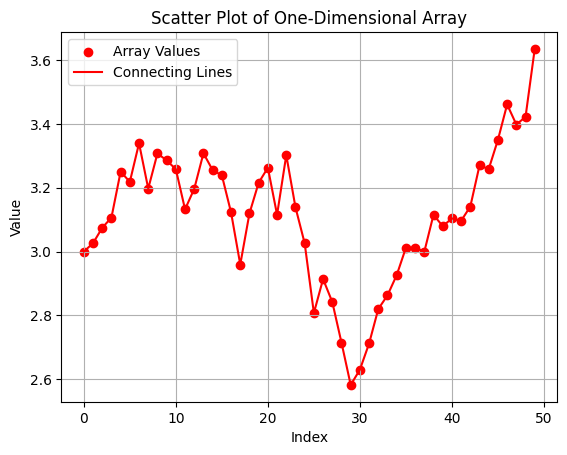

In [8]:
import matplotlib.pyplot as plt

def plot_values(values):
  # Generate indices for the x-axis
  x = np.arange(len(values))

  # Create a scatter plot
  plt.scatter(x, values, color='red', marker='o', label='Array Values')
  plt.plot(x, values, color='red', linestyle='-', label='Connecting Lines')

  # Add labels and title
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Scatter Plot of One-Dimensional Array')
  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()

plot_values(values)


I want to build a pipeline that checks for me that the data follows some patter.
For example:
  - the last data point is a resistance breaker or not.
  - the last data point is the end of a head and shoulders pattern.

So I must have a pipeline object, and within it, steps that return a boolean.

# Pipeline

In [60]:
class Pipeline():
  def __init__(self, pipeline=[]):
    self.pipeline = pipeline

  def add(self, stage):
    if stage.id in self.pipeline:
      raise ValueError("A stage in pipeline already contains this stage's id")
    self.pipeline += [stage]

  def remove(self, stage_id):
    self.pipeline = [s for s in self.pipeline if s.id != stage_id]

  def run(self, data, print_metadata=False):
    for s in self.pipeline:
      b, metadata = s.function(data)
      if print_metadata:
        print(f'{s.id}: {metadata}')

      if not b:
        return False
    return True


# function returns a tuple (bool, Dict). The second element is metadata about the result.
Stage = namedtuple('Stage', ['id', 'function'])

In [65]:
s_test = Stage(id='test', function=lambda s: ( (s > 3.1).all(), {'nb points above threshold:': (s > 3.1).sum()}))

In [66]:
p = Pipeline(pipeline=[])
p.add(s_test)
p.pipeline

[Stage(id='test', function=<function <lambda> at 0x7aa03bf11240>)]

In [67]:
p.run(np.array(values), print_metadata=True)

test: {'nb points above threshold:': 7}


False

In [64]:
p.pipeline

[Stage(id='test', function=<function <lambda> at 0x7aa03c0293f0>)]

In [ ]:
p.remove('test')
p.pipeline

[]

# Checker fucntions

## Resistance

In [ ]:
values

[3,
 3.025940234575424,
 3.0744366837367885,
 3.1063388589122467,
 3.250484617799,
 3.218449092208197,
 3.339476901021581,
 3.1972869930943246,
 3.307645789688192,
 3.285734023667368]

In [69]:
import numpy as np

def is_resistance(
    data,
    max_nb_historical_points,
    min_nb_historical_points,
    ratio_around_resistance,
    min_touch_occurences,
    min_points_between_touches,
    ratio_of_decrease=0.2):
    """
    Returns True if the last point is part of a resistance, else False.

    Filters the history by removing points before the latest point that exceeds
    last_point * (1 + ratio_around_resistance). Then checks for resistance with
    additional constraints on the minimum distance between touches and low-level condition.

    Arguments:
        - data:                     numpy array of points
        - max_nb_historical_points: maximum history size as number of points
        - min_nb_historical_points: minimum number of historical points in the filtered history
        - ratio_around_resistance:  ratio of tolerance around resistance level
        - min_touch_occurences:     number of times the resistance line is touched
        - min_points_between_touches: minimum points required between touches
        - ratio_of_decrease:        minimum ratio decrease from the resistance level required in history

    Returns:
        bool: True if the last point is part of a resistance, False otherwise.
    """
    metadata = {}
    # Ensure data length is sufficient
    if len(data) < max_nb_historical_points:
        raise ValueError("Insufficient data points for the specified history size.")

    # Get the last point and its tolerance threshold
    last_point = data[-1]
    tolerance_threshold = last_point * (1 + ratio_around_resistance)

    # Filter the history
    historical_data = data[-max_nb_historical_points:-1]  # Exclude the last point for resistance calculation
    crossing_indices = [i for i, point in enumerate(historical_data) if point > tolerance_threshold]

    if crossing_indices:
        # Cut history after the most recent crossing point
        historical_data = historical_data[crossing_indices[-1] + 1:]
    metadata.update({'len historical data': len(historical_data)})

    # Check if the filtered history meets minimum length requirement
    if len(historical_data) < min_nb_historical_points:
        return False, metadata

    # Determine the potential resistance level as the level of last point
    resistance_level = last_point

    # Define the tolerance range around the resistance level
    lower_bound = resistance_level * (1 - ratio_around_resistance)
    upper_bound = resistance_level * (1 + ratio_around_resistance)

    # Ensure the cut history has reached a low enough level
    required_low_level = resistance_level - resistance_level * ratio_of_decrease
    if np.min(historical_data) > required_low_level:
        return False, metadata

    # Count valid touches with min_points_between_touches enforcement
    touch_count = 0
    last_touch_index = -min_points_between_touches - 1  # Initialize as far enough back
    for i, point in enumerate(historical_data):
        if lower_bound <= point <= upper_bound:
            # Check if enough points have passed since the last touch
            if i - last_touch_index > min_points_between_touches:
                touch_count += 1
                last_touch_index = i
        elif point > upper_bound:  # Resistance is crossed
            return False, metadata

    # Return True if last point is near resistance and touch count condition is met
    b = touch_count >= min_touch_occurences
    metadata.update({'touch_count': touch_count})
    return b, metadata




## Epaule tête épaule inversée

In [9]:
def is_inverse_head_and_shoulders(
    data: np.array,
    max_nb_historical_points: int,
    min_length_head: int,
    min_length_shoulders: int,
    min_ratio_decrease_shoulder: float=None,
    min_ratio_decrease_head: float=None,
    tolerance_around_neckline: float=0.01,
):
  '''
  1. Local Minima Identification: The function identifies all local minima in the data.
  2. Triple Nested Loop: It uses a triple nested loop to generate all possible combinations of three local minima that respect the chronological order (left shoulder, head, right shoulder).
  3. Criteria Validation: For each valid combination, the function checks:
    - If the head is lower than both shoulders.
    - If the lengths of the head and shoulders meet the minimum requirements.
    - If the ratio decreases of the shoulders and head meet the specified criteria.
  4. Neckline Calculation: The function finds the maximum values between the left shoulder and the head, and between the head and the right shoulder. The neckline is formed by these maximum values.
  5. Tolerance Check: The function calculates the mean of max_left_shoulder_head and max_head_right_shoulder and defines the lower and upper bounds based on the tolerance. It then checks if max_left_shoulder_head, max_head_right_shoulder, and the last point fall within these bounds.
  6. Return Result: The function returns True if any combination meets all criteria, otherwise False.
  '''
  metadata = {}
  # Ensure the data is a numpy array
  data = np.array(data)

  if max_nb_historical_points <  min_length_head + 2 * min_length_shoulders:
    raise ValueError("The data array must contain at least min_length_head + 2 * min_length_shoulders elements.")

  # Truncate the data to the maximum number of historical points
  if len(data) > max_nb_historical_points:
      data = data[-max_nb_historical_points:]

  if len(data) < min_length_head + 2 * min_length_shoulders:
      return False, metadata

  # Find local minima
  local_minima = []
  for i in range(1, len(data) - 1):
      if data[i] < data[i-1] and data[i] < data[i+1]:
          local_minima.append((i, data[i]))

  # Ensure there are at least three local minima
  if len(local_minima) < 3:
      return False, metadata

  # Iterate through all combinations of three local minima
  for i in range(len(local_minima) - 2):
      for j in range(i + 1, len(local_minima) - 1):
          for k in range(j + 1, len(local_minima)):
              left_shoulder_idx, left_shoulder_val = local_minima[i]
              head_idx, head_val = local_minima[j]
              right_shoulder_idx, right_shoulder_val = local_minima[k]

              # Check if the head is lower than both shoulders
              if not (head_val < left_shoulder_val and head_val < right_shoulder_val):
                  continue

              # Find the maximum values between the shoulders and the head
              max_left_shoulder_head_idx = left_shoulder_idx + np.argmax(data[left_shoulder_idx:head_idx+1])
              max_left_shoulder_head = data[max_left_shoulder_head_idx]

              max_head_right_shoulder_idx = head_idx + np.argmax(data[head_idx:right_shoulder_idx+1])
              max_head_right_shoulder = data[max_head_right_shoulder_idx]

              # Check the lengths of the head and shoulders
              if (max_head_right_shoulder_idx - max_left_shoulder_head_idx) < min_length_head:
                  continue
              if (len(data) - 1 - max_head_right_shoulder_idx) < min_length_shoulders:
                  continue

              # Find the index of the last point before the left shoulder that crosses the neckline
              neckline_mean = (max_left_shoulder_head + max_head_right_shoulder) / 2
              neckline_lower_bound = (1 - tolerance_around_neckline) * neckline_mean
              neckline_upper_bound = (1 + tolerance_around_neckline) * neckline_mean

              left_shoulder_start_idx = next((idx for idx in range(left_shoulder_idx - 1, -1, -1) if data[idx] >= neckline_lower_bound), None)
              if left_shoulder_start_idx is None:
                  continue

              if (max_left_shoulder_head_idx - left_shoulder_start_idx) < min_length_shoulders:
                  continue

              # Check the ratio decrease of the shoulders and head
              if min_ratio_decrease_shoulder is not None:
                  if (left_shoulder_val / data[-1]) > (1 - min_ratio_decrease_shoulder) or (right_shoulder_val / data[-1]) > (1 - min_ratio_decrease_shoulder):
                      continue
              if min_ratio_decrease_head is not None:
                  if (head_val / data[-1]) > (1 - min_ratio_decrease_head):
                      continue

              # Check the tolerance around the neckline
              if not (neckline_lower_bound <= max_left_shoulder_head <= neckline_upper_bound):
                  continue
              if not (neckline_lower_bound <= max_head_right_shoulder <= neckline_upper_bound):
                  continue
              if not (neckline_lower_bound <= data[-1] <= neckline_upper_bound):
                  continue

              metadata.update({
                  'neckline_mean': neckline_mean,
                  'left_shoulder_start_idx': left_shoulder_start_idx
              })
              return True, metadata

  return False, metadata





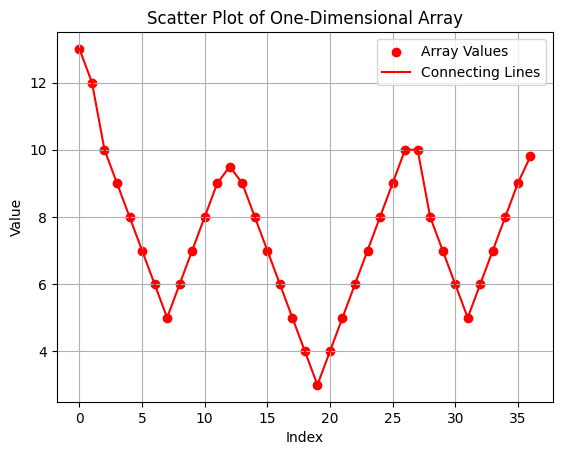

(True, {'neckline_mean': 9.75, 'left_shoulder_start_idx': 2})


In [14]:
# Example usage
data = np.array([13, 12, 10, 9, 8, 7, 6, 5, 6, 7, 8, 9, 9.5,
                 9, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 9, 10,
                 10, 8, 7, 6, 5, 6, 7, 8, 9, 9.8])

plot_values(data)

print(is_inverse_head_and_shoulders(
    data,
    max_nb_historical_points=50,
    min_length_head=3,
    min_length_shoulders=3,
    tolerance_around_neckline=0.05))

## is_above_k_times_previous_average

May be useful for checking high volume.

In [81]:
import numpy as np

def is_above_k_times_previous_average(
    data: np.array,
    k: float,
    N_previous_points: int
    ) -> bool:
    """
    Returns True if the last point is higher than k times the average of the N previous points (excluding the last point), else False.

    Parameters:
        data (np.array): The input array containing the data points.
        k (float): The multiplier to compare the last point against.
        N_previous_points (int): The number of previous points to calculate the moving average

    Returns:
        bool: True if the last point is higher than k times the moving average of the N previous points, else False.
    """
    if len(data) <= N_previous_points:
        raise ValueError("The data array must contain at least N_previous_points + 1 elements.")

    # Calculate the moving average of the N_previous_points before the last point
    moving_average = np.mean(data[-(N_previous_points + 1):-1])

    # Check if the last point is greater than k times the moving average
    return (data[-1] > k * moving_average, {'moving_average': moving_average})


In [83]:
is_above_k_times_previous_average(data=values, k=2, N_previous_points=5)

(False, {'moving_average': 3.37807569074048})

# Examples

In [ ]:
is_abo